In [87]:
%pylab inline
from scipy.stats import gaussian_kde
import tensorflow as tf
import crystal
from tensorflow.contrib.opt import ScipyOptimizerInterface
import pandas as pd
import simulate
from tensorflow.python.client import device_lib
import re

print("Version: {}".format(tf.__version__))
print(device_lib.list_local_devices())


Populating the interactive namespace from numpy and matplotlib
Version: 1.10.0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6137990567293734384
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4430102528
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11224701811374359589
physical_device_desc: "device: 0, name: Tesla K20m, pci bus id: 0000:04:00.0, compute capability: 3.5"
]


/n/home04/kmdalton/opt/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['gamma', 'indices', 'ion', 'norm', 'ioff']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [192]:
reflectionFN = 'test/reflections.csv.bz2'
imagedataFN = 'test/imagedata.csv.bz2'
referenceData = "test/dhfr/P21_Reference_Data.cns"
fcalcData = "test/dhfr/P21_Reference_Data_fmodel.cns"
outFN = "test/DHFR_DeltaFestimate.hkl"
spacegroupnumber = 4
ipm_number = 2

R = crystal.crystal().read_hkl(referenceData)
fcalc = crystal.crystal().read_hkl(fcalcData)
R['PHASE'] = fcalc['PHASE']
R.spacegroup = spacegroupnumber
R.unmerge()


SNR_CUTOFF = 0.1 #Minimum I/SIGMA(I)

I = pd.read_csv(reflectionFN)
I = I[I['IOBS']/I['SIGMA(IOBS)'] > SNR_CUTOFF]
#I['H'],I['K'] = I['K'],-I['H'] #Reindexing op for data integrated in P212121
I = crystal.crystal(I.set_index(['H', 'K', 'L']))
I.spacegroup = spacegroupnumber
I.populate_merged_hkls()

M = pd.read_csv(imagedataFN).set_index('Image#')
M['SERIES'] = M['file_name'].apply(lambda x: 'off' if 'off' in x else 'on') + M['file_name'].apply(lambda x: x.split('/')[-1].split('_')[0])
M['RUN'] = M['file_name'].apply(lambda x:int(re.search(r'(?<=r)[0-9]*', x).group()))
M['PHINUMBER'] = M['file_name'].apply(lambda x : int(re.search(r'(?<=_)[0-9]+(?=.tiff)', x).group()))

I = I.reset_index().merge(M.reset_index(), on='Image#')

(3, 3566724)


In [211]:
from importlib import reload
reload(crystal)
referenceData = "test/dhfr/P21_Reference_Data.cns"
fcalcData = "test/dhfr/P21_Reference_Data_fmodel.cns"
outFN = "test/DHFR_DeltaFestimate.hkl"
spacegroupnumber = 4
ipm_number = 2


FOBS         D       PHASE  MERGEDH  MERGEDK  MERGEDL
H   K  L                                                           
-38  0 1   13.5817  1.185777  180.000000      -38        0        1
       2   21.0066  1.185528  180.000000      -38        0        2
       3   14.0681  1.185107  180.000000      -38        0        3
       4   13.4919  1.184515    0.000000      -38        0        4
       5   17.6542  1.183753  180.000000      -38        0        5
       6   15.6492  1.182822    0.000000      -38        0        6
       7   15.4324  1.181723    0.000000      -38        0        7
       8   13.7731  1.180457  180.000000      -38        0        8
       9   18.3007  1.179027    0.000000      -38        0        9
       12  13.9942  1.173765    0.000000      -38        0       12
       13  13.6760  1.171694  180.000000      -38        0       13
       16  13.0561  1.164571    0.000000      -38        0       16
       17  12.3534  1.161901    0.000000      -38        0       17
     1 1   19.4637  1.185061   11.036000      -38        1        1
       3   19.5362  1.184392 -179.656000      -38        1        3
       4   17.2382  1.183801  130.215000      -38        1        4
       5   17.7361  1.183041  151.049000      -38        1        5
       6   18.4068  1.182111   22.273600      -38        1        6
       8   18.7028  1.179751  -65.854100      -38        1        8
       10  18.2976  1.176732 -152.014000      -38        1       10
       11  22.1384  1.174980   23.205300      -38        1       11
       12  18.9928  1.173070   77.512500      -38        1       12
     2 1   17.7037  1.182920  -25.123400      -38        2        1
       3   17.8086  1.182255    3.340840      -38        2        3
       5   24.7809  1.180911  132.665000      -38        2        5
       6   22.4043  1.179986   97.518400      -38        2        6
       7   19.1592  1.178895  156.099000      -38        2        7
       11  20.4236  1.172893  -95.169600      -38        2       11
     3 1   18.2300  1.179378  149.676000      -38        3        1
       3   20.9863  1.178718  -37.081500      -38        3        3
...            ...       ...         ...      ...      ...      ...
 37 -7 4   19.7328  1.180152   57.638700       37        7        4
       5   20.8773  1.179383  121.134000       37        7        5
       6   17.4258  1.178446  129.320000       37        7        6
       7   18.2174  1.177343  -43.746200       37        7        7
    -8 1   18.0577  1.170955   48.558100       37        8        1
       4   17.5788  1.169693  -27.662700       37        8        4
 38 -1 0   19.8562  1.185139  -15.113400       38        1        0
       1   16.3585  1.185045  170.844000       38        1        1
       2   17.8386  1.184779  106.630000       38        1        2
       5   16.4444  1.182959   19.674400       38        1        5
       8   19.1571  1.179621   60.920200       38        1        8
    -2 0   17.3719  1.182997   -1.580060       38        2        0
       1   20.4274  1.182904 -142.596000       38        2        1
       3   20.1349  1.182206  165.910000       38        2        3
       4   19.4127  1.181602  121.779000       38        2        4
       5   18.5783  1.180829   40.568700       38        2        5
       7   17.2468  1.178782   12.906200       38        2        7
       9   16.9965  1.176074   53.035600       38        2        9
       11  20.2139  1.172718  -91.267700       38        2       11
       13  17.0480  1.168733  -91.978900       38        2       13
    -3 0   18.2793  1.179454  123.529000       38        3        0
       1   17.8471  1.179362   33.406200       38        3        1
       3   17.5633  1.178670 -146.335000       38        3        3
       4   17.4847  1.178071   70.624100       38        3        4
       6   20.6074  1.176374  117.637000       38        3        6
       8   18.5598  1.174015 -103.525000       38        3        8
  

-0.09802199935148179

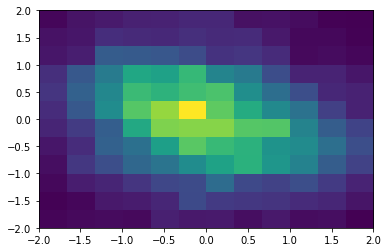

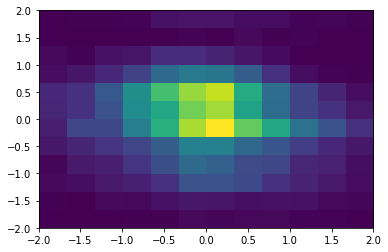

In [193]:
IPM2_X = (I.ipm2_xpos - I.ipm2_xpos.mean())/I.ipm2_xpos.std()
XDS_X  = (I.incident_beam_x - I.incident_beam_x.mean())/I.incident_beam_x.std()
_ = plt.hist2d(IPM2_X, XDS_X, 12, ((-2, 2), (-2, 2)))

np.corrcoef(IPM2_X, XDS_X)[0,1]

plt.figure()
IPM2_Y = (I.ipm2_ypos - I.ipm2_ypos.mean())/I.ipm2_ypos.std()
XDS_Y  = (I.incident_beam_y - I.incident_beam_y.mean())/I.incident_beam_y.std()
_ = plt.hist2d(IPM2_Y, XDS_Y, 12, ((-2, 2), (-2, 2)))

np.corrcoef(IPM2_Y, XDS_Y)[0,1]

In [194]:
keepcols = [
    'H',
    'K',
    'L',
    'MERGEDH',
    'MERGEDK',
    'MERGEDL',
    'IOBS',
    'SIGMA(IOBS)',
    'ipm2',
    'ipm3',
    'ipm2_xpos',
    'ipm3_xpos',
    'ipm2_ypos',
    'ipm3_ypos',
    'RUN',
    'PHINUMBER',
    'SERIES'
]

I = I[[i for i in keepcols]]


In [195]:
print("Number of reflection observations: {}".format(len(I)))
print("Multiplicity: {}".format(len(I)/len(I.groupby(['H', 'K', 'L']))))

#This removes reflections which were not observed in the 'on' and 'off' datasets at a given rotation
#This line is hilariously slow and should be sped up at some point. 
I = I.groupby(['H', 'K', 'L', 'RUN', 'PHINUMBER']).filter(lambda x: x.SERIES.str.contains('on').max() and x.SERIES.str.contains('off').max())

gammaobs = len(I.groupby(['H', 'K', 'L', 'RUN', 'PHINUMBER']))
gammamult = gammaobs / len(I.groupby(['H', 'K', 'L']))
print("Number of gamma observations: {}".format(gammaobs))
print("Multiplicity: {}".format(gammamult))

Number of reflection observations: 3566724
Multiplicity: 29.217720399102184
Number of gamma observations: 519947
Multiplicity: 4.606641327556725


In [196]:
"""
#########################################################
It is important to establish some numerical indices in 
order to index arrays in the optimization problem. 

----------
GAMMAINDEX
----------
    A unique numeric index is assigned to each combination
    of H, K, and L. This index uses the "MERGEDH/K/L" 
    attributes in the dataframe. This way we don't estimate
    more gammas than are truly necessary. This should not be
    used for grouping observations to make ratiometric 
    observations, because it will group together equivalent
    observations in a single image should they exist. That
    would be problematic, because equivalent observations will
    certainly not have the same partiality.

--------
RUNINDEX
--------
    A unique, sequential identifier for each run/crystal.
    Use this for indexing per crystal parameters.

----------
IMAGEINDEX
----------
    A unique, sequential identifier for each image in the 
    dataset. Use this for adding per shot parameters. 

--------
PHIINDEX
--------
    A unique, sequential identifier for each group of shots
    on the same crystal at the same rotation angle. 


#########################################################
"""

indices = {
    'GAMMAINDEX' : ['MERGEDH', 'MERGEDK', 'MERGEDL'], 
    'RUNINDEX'   : 'RUN', 
    'IMAGEINDEX' : ['RUN', 'PHINUMBER', 'SERIES'],
    'PHIINDEX'   : ['RUN', 'PHINUMBER'],
}

for k,v in indices.items():
    I[k] = I.groupby(v).ngroup()

In [197]:

k = [i for i in I if 'ipm' in i.lower()]
k += ['RUNINDEX']#, 'Io']
imagemetadata = I[k + ['IMAGEINDEX']].groupby('IMAGEINDEX').mean()
imagemetadata['IPM']   = imagemetadata['ipm{}'.format(ipm_number)]
imagemetadata['IPM_X'] = imagemetadata['ipm{}_xpos'.format(ipm_number)]
imagemetadata['IPM_Y'] = imagemetadata['ipm{}_ypos'.format(ipm_number)]
imagemetadata

,ipm2,ipm3,ipm2_xpos,ipm3_xpos,ipm2_ypos,ipm3_ypos,RUNINDEX,IPM,IPM_X,IPM_Y
IMAGEINDEX,,,,,,,,,,
0,0.254835,0.275872,-0.018381,0.018735,0.136058,0.591125,0,0.254835,-0.018381,0.136058
1,0.218671,0.233680,-0.012491,0.015180,0.127141,0.594573,0,0.218671,-0.012491,0.127141
2,0.175869,0.190726,-0.030969,0.006084,0.116510,0.613592,0,0.175869,-0.030969,0.116510
3,1.123760,1.193244,-0.027488,0.006590,0.130279,0.588278,0,1.123760,-0.027488,0.130279
4,0.494249,0.532147,-0.023908,0.006495,0.131232,0.593146,0,0.494249,-0.023908,0.131232
5,0.468995,0.508724,-0.012981,0.014155,0.138520,0.601169,0,0.468995,-0.012981,0.138520
6,0.344253,0.375971,-0.016441,0.017851,0.119454,0.591636,0,0.344253,-0.016441,0.119454
7,0.168316,0.188972,-0.026316,0.012817,0.142453,0.590390,0,0.168316,-0.026316,0.142453
8,0.159466,0.174018,-0.026935,0.007367,0.125178,0.606651,0,0.159466,-0.026935,0.125178


In [198]:
iobs        = I.pivot_table(values='IOBS', index=['H', 'K', 'L', 'RUNINDEX','PHIINDEX'], columns='SERIES', fill_value=np.NaN) 
imagenumber = I.pivot_table(values='IMAGEINDEX', index=['H', 'K', 'L', 'RUNINDEX', 'PHIINDEX'], columns='SERIES', fill_value=-1)
ion    = iobs[[i for i in iobs if  'on' in i]].sum(1) 
ioff   = iobs[[i for i in iobs if 'off' in i]].sum(1)
gammas = ion / ioff

gammaidx = I.pivot_table(values='GAMMAINDEX', index=['H', 'K', 'L', 'RUNINDEX','PHIINDEX'])
gammaidx = np.array(gammaidx).flatten()

sigma       = I.pivot_table(values='SIGMA(IOBS)', index=['H', 'K', 'L', 'RUNINDEX','PHIINDEX'], columns='SERIES', fill_value=np.NaN) 
sigmaion    = np.sqrt(np.square(iobs[[i for i in iobs if  'on' in i]]).sum(1))
sigmaioff   = np.sqrt(np.square(iobs[[i for i in iobs if 'off' in i]]).sum(1))
sigmagamma  = np.abs(gammas)*np.sqrt(np.square(sigmaion / ion) + np.square(sigmaioff / ioff))
mergingweights = (1. / np.array(sigmagamma, dtype=float32)) * ((1./np.array([(1./sigmagamma.iloc[gammaidx == i]).sum() for i in range(gammaidx.max() + 1)], dtype=float32))[gammaidx])

H = np.array(I.groupby('GAMMAINDEX').mean()['MERGEDH'], dtype=int)
K = np.array(I.groupby('GAMMAINDEX').mean()['MERGEDK'], dtype=int)
L = np.array(I.groupby('GAMMAINDEX').mean()['MERGEDL'], dtype=int)

FOBS = np.array(R.loc[zip(H, K, L), 'FOBS'])
FOBS[np.isnan(FOBS)] = 0

/n/home04/kmdalton/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:979: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_nested_tuple(tup)


In [199]:
tf.reset_default_graph()
h = gammaidx.max() + 1

r = len(gammas.reset_index().groupby('RUNINDEX'))
runidx = np.array(imagemetadata['RUNINDEX'])
epsilon = 0.


#We need two sparse tensors to map from Icryst estimates into the liklihood function. 
#First the 'on' shots
tmp = np.array(imagenumber[[i for i in imagenumber if 'on' in i]])
idx = np.vstack((np.indices(tmp.shape)[0][tmp >= 0], tmp[tmp >= 0])).T
onimageidx = tf.SparseTensor(idx, np.ones(len(idx), dtype=np.float32), (len(imagenumber), len(imagemetadata)))
onimageidx = tf.sparse_reorder(onimageidx)

#Now the 'off' shots
tmp = np.array(imagenumber[[i for i in imagenumber if 'off' in i]])
idx = np.vstack((np.indices(tmp.shape)[0][tmp >= 0], tmp[tmp >= 0])).T
offimageidx = tf.SparseTensor(idx, np.ones(len(idx), dtype=np.float32), (len(imagenumber), len(imagemetadata)))
offimageidx = tf.sparse_reorder(offimageidx)

#Let us have a sparse matrix for averaging hkl observations
idx = np.vstack((
    gammaidx,
    np.arange(len(gammaidx), dtype=int), 
)).T
tshape = (
    gammaidx.max()+1,
    len(gammaidx), 
)
#vals = np.array((1./sigmagamma).groupby(['MERGEDH', 'MERGEDK', 'MERGEDL']), dtype=float32)[gammaidx] / np.array(sigmagamma, dtype=float32)
vals = mergingweights
mergingtensor = tf.SparseTensor(idx, vals, tshape)
mergingtensor = tf.sparse_reorder(mergingtensor)



#Constants 
raw_gammas = tf.constant(np.float32(gammas))
ipm        = tf.constant(np.float32(imagemetadata['IPM']))
ipm_x      = tf.constant(np.float32(imagemetadata['IPM_X']))
ipm_y      = tf.constant(np.float32(imagemetadata['IPM_Y']))
F          = tf.constant(np.float32(FOBS))

#Regularization strength
#rho = tf.placeholder(tf.float32)

#LCs for scaling IPM data
#x_slope_ = 5000.
x_intercept   = tf.constant(imagemetadata.IPM_X.mean())
x_slope       = tf.constant(1./imagemetadata.IPM_X.std())
y_intercept   = tf.constant(imagemetadata.IPM_Y.mean())
y_slope       = tf.constant(1./imagemetadata.IPM_Y.std())
ipm_intercept = tf.Variable(0.0)
ipm_slope     = tf.constant(1.)
#ipm_slope     = tf.constant(1.)

#Beam shape
sigx          = tf.constant(50.)
sigy          = tf.constant(50.)
#sigx          = tf.Variable(100.)
#sigy          = tf.Variable(100.)

#Crystal dimensions
xpos = tf.Variable(np.zeros(r, dtype=np.float32))
ypos = tf.Variable(np.zeros(r, dtype=np.float32))
width  = tf.Variable(np.sqrt(50.)*np.ones(r, dtype=np.float32))
height = tf.Variable(np.sqrt(50.)*np.ones(r, dtype=np.float32))
xmin   = xpos - 0.5*tf.square(width)
xmax   = xpos + 0.5*tf.square(width)
ymin   = ypos - 0.5*tf.square(height)
ymax   = ypos + 0.5*tf.square(height)
#xmin          = tf.Variable(-50.*np.ones(r, dtype=np.float32))
#xmax          = tf.Variable( 50.*np.ones(r, dtype=np.float32))
#ymin          = tf.Variable(-50.*np.ones(r, dtype=np.float32))
#ymax          = tf.Variable( 50.*np.ones(r, dtype=np.float32))

#gammastimates
gamma         = tf.Variable(np.ones(h), dtype=np.float32)

beamx  = ipm_x * x_slope + x_intercept
beamy  = ipm_y * y_slope + y_intercept


Icryst = 0.25*(ipm_slope*ipm + ipm_intercept) * (
    tf.erf((tf.gather(xmin, runidx) - beamx)/sigx) - tf.erf((tf.gather(xmax, runidx) - beamx)/sigx)
    ) * (
    tf.erf((tf.gather(ymin, runidx) - beamy)/sigy) - tf.erf((tf.gather(ymax, runidx) - beamy)/sigy)
    )

Bon  = tf.squeeze(tf.sparse_tensor_dense_matmul( onimageidx, tf.expand_dims(Icryst, 1)))
Boff = tf.squeeze(tf.sparse_tensor_dense_matmul(offimageidx, tf.expand_dims(Icryst, 1)))


#g = tf.maximum(raw_gammas*Boff/Bon, 0.)
#g = raw_gammas*Boff/(Bon + epsilon)
g = tf.squeeze(tf.sparse_tensor_dense_matmul(mergingtensor, tf.expand_dims(raw_gammas*Boff/(Bon + epsilon), 1)))
#deltaF = tf.sqrt(g) - 1.
deltaFoverF = (tf.sqrt(g) - 1.)
#deltaFoverF = tf.squeeze(tf.sparse_tensor_dense_matmul(mergingtensor, tf.expand_dims(deltaFoverF_unmerged, 1)))
deltaF = F*deltaFoverF
loss = tf.reduce_sum(tf.abs(deltaF))

0: 535189.75
100: 534759.875
200: 534736.875
300: 534706.625
400: 534670.875
500: 534630.5
600: 534586.125
700: 534538.5
800: 534487.875
900: 534434.5625
1000: 534379.375
1100: 534323.375
1200: 534266.0
1300: 534207.6875
1400: 534149.25
1500: 534090.6875
1600: 534032.375
1700: 533975.0
1800: 533918.4375
1900: 533863.375
2000: 533809.75
2100: 533756.8125
2200: 533704.5
2300: 533653.25
2400: 533602.625
2500: 533552.125
2600: 533501.125
2700: 533449.625
2800: 533397.125
2900: 533344.125
3000: 533291.125
3100: 533237.5625
3200: 533183.375
3300: 533129.125
3400: 533073.875
3500: 533018.125
3600: 532964.0625
3700: 532909.75
3800: 532854.9375
3900: 532799.0
4000: 532742.8125
4100: 532686.4375
4200: 532629.5625
4300: 532572.5
4400: 532514.625
4500: 532455.5625
4600: 532396.8125
4700: 532337.8125
4800: 532278.6875
4900: 532219.5
5000: 532159.5625
5100: 532098.9375
5200: 532038.4375
5300: 531976.625
5400: 531915.25
5500: 531853.75
5600: 531791.4375
5700: 531728.9375
5800: 531666.75
5900: 531603.

No handles with labels found to put in legend.


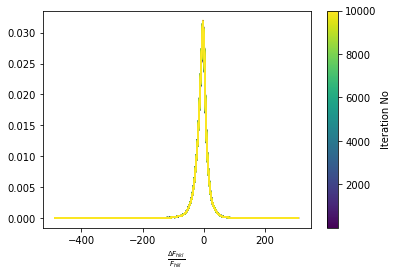

<Figure size 432x288 with 0 Axes>

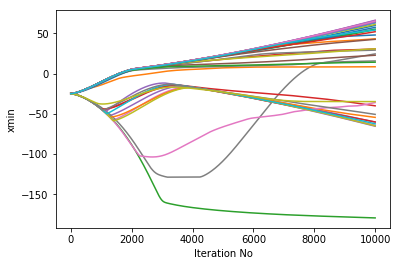

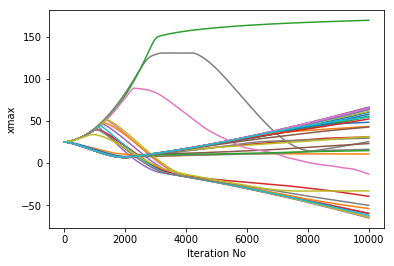

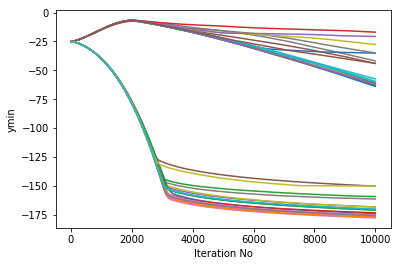

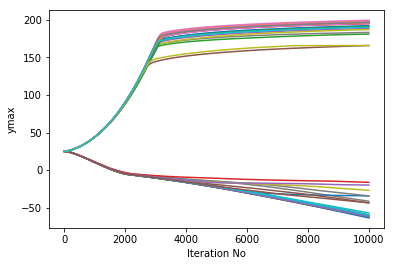

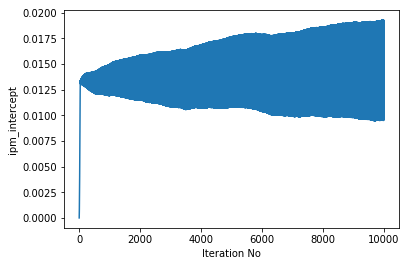

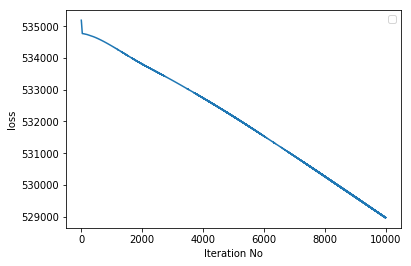

In [206]:
from tensorflow.contrib.opt import ScipyOptimizerInterface

var_groups = {
    'IPM Intercept' : ipm_intercept,
    'Crystal Dims'  : [xmin, xmax, ymin, ymax],
}

#optimizers = {k:tf.train.AdagradOptimizer(0.5).minimize(loss, var_list=v) for k,v in var_groups.items()}
#optimizer = tf.train.AdagradOptimizer(.05).minimize(loss)
#optimizer = tf.train.AdamOptimizer(.01).minimize(loss)
optimizer = tf.train.AdadeltaOptimizer(1., .01).minimize(loss)
#bfgsoptimizer = ScipyOptimizerInterface(loss, var_list=[xmin, xmax, ymin, ymax])
#bfgsoptimizer = ScipyOptimizerInterface(loss)



nsteps = 10000
verbose=False
cmap = plt.get_cmap()
norm = plt.Normalize(vmin=1., vmax=nsteps)
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array((1., nsteps))



logvars = {
    'xmin': xmin,
    'xmax': xmax,
    'ymin': ymin,
    'ymax': ymax,
    #'sigx': sigx,
    #'sigy': sigy,
    #'Icryst': Icryst,
    #'ipm_slope' : ipm_slope, 
    #'Bon' : Bon,
    #'Boff': Boff,
    #'x_slope' : x_slope, 
    #'y_slope' : y_slope, 
    #'gamma' : g,
    #'deltaF unmerged': deltaF_unmerged,
    #'deltaF' : deltaF,
    'ipm_intercept' : ipm_intercept, 
    'loss' : loss,
    #'regularizer' : regularizer,
    #'absolute_deviation' : absolute_deviation,
}

L = {k:[] for k in logvars}
#L['loss'] = []
deltaF_ = None
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for k,v in logvars.items():
        L[k].append(sess.run(v))
    print("0: {}".format(L['loss'][-1]))
    for i in range(nsteps):
        _,loss_ = sess.run((optimizer, loss))
        #optimizer.minimize(sess)
        #for k,v in optimizers.items(): #sess.run(v)
        for k,v in logvars.items():
            L[k].append(sess.run(v))
        if np.isnan(L['loss'][-1]):
            for k,v in logvars.items():
                L[k].append(sess.run(v))
            break
        #print("{}: {}".format(i+1, L['loss'][-1]))
        deltaF_ = sess.run(deltaF)
        if (i + 1) % 100 == 0:
            #bfgsoptimizer.minimize(sess)
            print("{}: {}".format(i+1, L['loss'][-1]))
            x1, x2  = deltaF_.min(),deltaF_.max()
            X = np.linspace(x1 - 0.1*(x2 - x1), x2 + 0.1*(x2 - x1), 200)
            plt.plot(X, gaussian_kde(deltaF_)(X), c=sm.to_rgba(i+1))
        
        

plt.colorbar(sm, ax=plt.gca(), label='Iteration No')
plt.xlabel(r'$\frac{\Delta F_{hkl}} {F_{hkl}}$')

plotvars = ['xmin', 'xmax', 'ymin', 'ymax', 'ipm_intercept', 'loss']

plt.figure()
for k in plotvars:
    v = L[k]
    plt.figure()
    plt.plot(v)
    plt.ylabel(k)
    plt.xlabel('Iteration No')
plt.legend()

[]

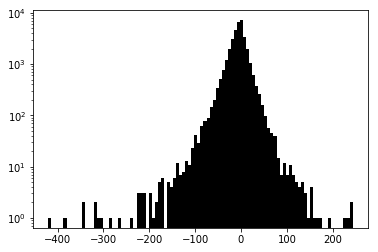

In [208]:
_ = hist(deltaF_, 100, color='k')
plt.semilogy()

In [203]:
H = np.array(I.groupby('GAMMAINDEX').mean()['MERGEDH'], dtype=int)
K = np.array(I.groupby('GAMMAINDEX').mean()['MERGEDK'], dtype=int)
L = np.array(I.groupby('GAMMAINDEX').mean()['MERGEDL'], dtype=int)

O = R.loc[zip(H, K, L)]
O['DeltaF'] = deltaF_
O = O.dropna()
O._coerce_dtypes()
O

/n/home04/kmdalton/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """


FOBS       PHASE         D  MERGEDH  MERGEDK  MERGEDL  \
H  K   L                                                                
0  -19 22  109.11400  179.383000  1.665952        0       19       22   
       23   40.64010  -95.151000  1.655331        0       19       23   
   -18 19  133.67500   90.533400  1.779443        0       18       19   
       20   72.46250    0.092487  1.768224        0       18       20   
       21  169.95100  -88.949000  1.756656        0       18       21   
       22   12.27640   15.877200  1.744765        0       18       22   
       23   84.60720   87.056400  1.732575        0       18       23   
       24    8.26230   48.928600  1.720112        0       18       24   
       25   84.41600   86.806300  1.707401        0       18       25   
       26   12.18610   -0.202282  1.694467        0       18       26   
       27   49.11000  -91.536200  1.681331        0       18       27   
       28   91.42340  175.954000  1.668018        0       18       28   
       29   57.71970  -88.598000  1.654549        0       18       29   
   -17 16   40.39330   -8.267270  1.907289        0       17       16   
       17  124.40300   90.411700  1.895597        0       17       17   
       18  119.62700  177.334000  1.883428        0       17       18   
       19   95.31260   94.315800  1.870815        0       17       19   
       20  178.96600    0.392887  1.857791        0       17       20   
       21   20.00480   79.696900  1.844388        0       17       21   
       22   32.61170  170.934000  1.830639        0       17       22   
       23  144.48600  -90.417500  1.816574        0       17       23   
       24   24.61210 -161.294000  1.802225        0       17       24   
       25   28.32650  106.953000  1.787621        0       17       25   
       26    4.52473 -176.629000  1.772792        0       17       26   
       27   55.79330  -89.004400  1.757766        0       17       27   
       28   64.78330   -0.060352  1.742570        0       17       28   
       29   32.42910  -90.943900  1.727230        0       17       29   
       30    9.91442  -24.518600  1.711771        0       17       30   
       31   19.55840   60.022600  1.696217        0       17       31   
       32   66.22580   -4.723120  1.680589        0       17       32   
...              ...         ...       ...      ...      ...      ...   
26  3  10   30.90210 -132.633000  1.687857       26        3       10   
       11  102.33200   33.599400  1.682662       26        3       11   
       12   51.56650  -33.926000  1.677028       26        3       12   
       13   25.95250  -29.188200  1.670969       26        3       13   
       14   60.08930   38.098100  1.664500       26        3       14   
       16   88.64610  -42.562300  1.650393       26        3       16   
    4  2    51.41950 -155.354000  1.697375       26        4        2   
       3    62.64070   60.187900  1.696101       26        4        3   
       4    68.24260  -30.155900  1.694328       26        4        4   
       5    53.13050 -157.646000  1.692062       26        4        5   
       6    70.43590 -102.171000  1.689307       26        4        6   
       7   101.81100  115.813000  1.686072       26        4        7   
       8    45.75300   67.771000  1.682363       26        4        8   
       9    55.85330  160.182000  1.678192       26        4        9   
       10  106.68600  155.434000  1.673569       26        4       10   
       13   19.83020   92.466600  1.657102       26        4       13   
    5  1     9.72437 -146.609000  1.679509       26        5        1   
       2    28.96810   93.289900  1.678762       26        5        2   
       3    96.98450 -130.158000  1.677530       26        5        3   
       4    14.89930   82.313500  1.675815       26        5        4   
       5    74.90180   24.223300  1.673622       26        5        5   
       6   119.49000  -37.828300  1.670956       26        5        6   
 

In [204]:
reflections = []
for (h,k,l), D in O.iterrows():
    reflections.append("INDE {} {} {} FOBS= {} {}\n".format(h,k,l,D['DeltaF'],D['PHASE']))
    
#header = ''.join([i for i in open(referenceData) if i[:4]!='INDE'])
header = """{ sg=P2(1) a=45.062 b=34.102 c=98.495 alpha=90 beta=90.03 gamma=90 }
NREFlections=1034
ANOMalous=FALSE
DECLare NAME=FOBS DOMAin=RECIprocal TYPE=COMPLEX END
"""

header = re.sub(r"(?<=NREFlections\=)[0-9]+", str(len(reflections)), header)
print(header)

with open(outFN, 'w') as out:
    out.write(header)
    out.write(''.join(reflections))

{ sg=P2(1) a=45.062 b=34.102 c=98.495 alpha=90 beta=90.03 gamma=90 }
NREFlections=35296
ANOMalous=FALSE
DECLare NAME=FOBS DOMAin=RECIprocal TYPE=COMPLEX END



"\nO.loc[np.abs(O['DeltaF']) < np.percentile(np.abs(O['DeltaF']), highpass), 'DeltaF'] = 0.\nplt.figure()\nplt.scatter(O['D'], O['DeltaF'], edgecolors='k', facecolors='none', alpha=0.05)\nplt.figure()\nplt.scatter(O['FOBS'], O['DeltaF'], edgecolors='k', facecolors='none', alpha=0.05)\n"

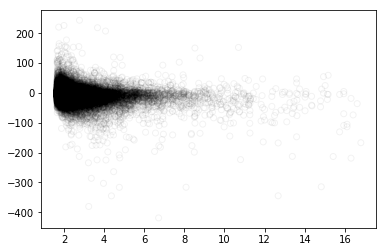

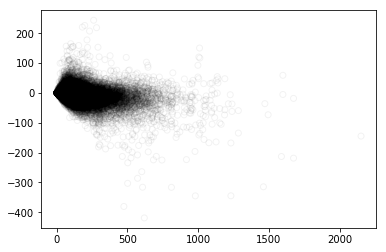

In [205]:
#highpass=99.9

plt.figure()
plt.scatter(O['D'], O['DeltaF'], edgecolors='k', facecolors='none', alpha=0.05)
plt.figure()
plt.scatter(O['FOBS'], O['DeltaF'], edgecolors='k', facecolors='none', alpha=0.05)

"""
O.loc[np.abs(O['DeltaF']) < np.percentile(np.abs(O['DeltaF']), highpass), 'DeltaF'] = 0.
plt.figure()
plt.scatter(O['D'], O['DeltaF'], edgecolors='k', facecolors='none', alpha=0.05)
plt.figure()
plt.scatter(O['FOBS'], O['DeltaF'], edgecolors='k', facecolors='none', alpha=0.05)
"""

In [ ]:
tf.reset_default_graph()

ion  = iobs[[i for i in iobs if 'on' in i]]
idx  = np.where(~np.isnan(ion))
imidx= np.array(imagenumber[[i for i in iobs if 'on' in i]])[idx]
vals = np.array(ion, dtype=float32)[idx]
N = tf.SparseTensor(np.vstack((idx[0], imidx)).T, vals, (len(ion), len(imagemetadata)))
N = tf.sparse_reorder(N)

ioff = iobs[[i for i in iobs if 'off' in i]]
idx  = np.where(~np.isnan(ioff))
imidx= np.array(imagenumber[[i for i in iobs if 'off' in i]])[idx]
vals = np.array(ioff, dtype=float32)[idx]
F = tf.SparseTensor(np.vstack((idx[0], imidx)).T, vals, (len(ioff), len(imagemetadata)))
F = tf.sparse_reorder(F)

#Let us have a sparse matrix for averaging hkl observations
idx = np.vstack((
    gammaidx,
    np.arange(len(gammaidx), dtype=int), 
)).T
tshape = (
    gammaidx.max()+1,
    len(gammaidx), 
)
vals = np.array(1./np.bincount(gammaidx)[gammaidx], dtype=float32)
mergingtensor = tf.SparseTensor(idx, vals, tshape)
mergingtensor = tf.sparse_reorder(mergingtensor)

B = tf.Variable(np.ones(len(imagemetadata), dtype=float32))



Ion  = tf.squeeze(tf.sparse_tensor_dense_matmul(N, tf.expand_dims(B, 1)))
Ioff = tf.squeeze(tf.sparse_tensor_dense_matmul(F, tf.expand_dims(B, 1)))

deltaI = tf.squeeze(tf.sparse_tensor_dense_matmul(mergingtensor, tf.expand_dims(tf.sqrt(Ion) - tf.sqrt(Ioff), 1)))
gamma  = tf.squeeze(tf.sparse_tensor_dense_matmul(mergingtensor, tf.expand_dims(Ion / Ioff, 1)))
deltaF = tf.sqrt(gamma) - 1.
np.sum(np.isnan(deltaFoverF))

loss = tf.reduce_sum(tf.abs(deltaI))